# zerina project

## setup

In [1]:
import pandas as pd
import numpy as np
import scipy
from tqdm import tqdm_notebook

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


## data processing

### read csv and preprocess

In [47]:
tar_file = r'data/wifitrafficstats2.csv'
#tar_file = r'data/wifitrafficstats3.csv'
#tar_file = r'data/wifitrafficstats4.csv'
#tar_file = r'data/wifitrafficstats5.csv'
#tar_file = r'data/wifitrafficstats6.csv'

df = (
    pd
    .read_csv(tar_file)
    .rename({ 
        'Time':'time', 
        'Length':'length', 
        'TX Rate':'rate'
    }, axis=1)
    .eval('time = time * 1e6')
    .eval('rate = rate * 1e6')
    .eval('length = length * 8')
    .eval('on_time = 1e6 * length / rate')
    .eval('end_time = time + on_time')
    .assign(
        shift_time = lambda x: x.end_time.shift(1),
        off_time = lambda x: [
            (time - shift_time) 
                if (time - shift_time) > 0 else 0 
            for time, shift_time in (zip(x.time, x.shift_time))
    ])
    .drop(['No.','Delta Time','shift_time'], axis=1)
    .round(0)
)



df.head(10)

,time,length,rate,on_time,end_time,off_time
0,0.0,1352,6000000.0,225.0,225.0,0.0
1,36341.0,312,24000000.0,13.0,36354.0,36116.0
2,39469.0,312,24000000.0,13.0,39482.0,3115.0
3,49356.0,2288,1000000.0,2288.0,51644.0,9874.0
4,50556.0,1008,1000000.0,1008.0,51564.0,0.0
5,64737.0,6584,6000000.0,1097.0,65834.0,13173.0
6,82497.0,312,24000000.0,13.0,82510.0,16663.0
7,85683.0,312,24000000.0,13.0,85696.0,3173.0
8,101354.0,312,6000000.0,52.0,101406.0,15658.0
9,103643.0,456,12000000.0,38.0,103681.0,2237.0


### generate data list of `1`'s and `0`'s

In [65]:
# simpler way
data_list = []

for row in tqdm_notebook(df[['on_time','off_time']].iloc[1:].itertuples(), total=df.shape[0]-1):
    data_list.extend([1 for i in range(int(row.on_time))])
    data_list.extend([0 for i in range(int(row.off_time))])

In [63]:
# this method is unncessary complicated, but it runs twice as fast..
data_list = [
    item for sublist in
    [
        [1 for i in range(int(row.on_time))] + [0 for i in range(int(row.off_time))]
        for row in tqdm_notebook(
            df[['on_time','off_time']].iloc[1:].itertuples(), 
            total=df.shape[0]-1
        )
    ]
    for item in sublist
]

### downsample 10x

note: investigate `scipy.signal.decimate` and `scipy.signal.resample`

In [124]:
# reshape into rows of 10, take mean of each row to create new array
down_sample_factor = 10

data_list_down10 = (
    data_list
    .reshape(-1, down_sample_factor)
    .mean(axis=1, dtype='int')
)

assert len(data_list) / len(data_list_down10) == down_sample_factor

### create state length feature

In [125]:
prev = 1
same_state_count = 0
running_total = []

for val in tqdm_notebook(data_list_down10):    
    
    # if same
    if (val - prev) == 0:
        same_state_count += 1
        running_total.append(same_state_count)
        
        prev = val
    
    # if going 1 -> 0 or 0 -> 1
    else:
        same_state_count = 0
        running_total.append(same_state_count)
        
        prev = val

### fast get all state lengths

In [129]:
%%time
data_list = np.array(data_list_down10)

state_lengths = np.diff(
    np.where(
        np.concatenate(
            ([data_list[0]],
             data_list[:-1] != data_list[1:],
             [0]
            )
        )
    )[0]
)[::2]

display(state_lengths[:20])

array([  1,   1, 228, 210,   1,   5,   3,   3,   1,   1,   1,  21, 109,
        62, 230,   2,   1,  30,  31, 109], dtype=int64)

Wall time: 66.2 ms


### final processing

In [130]:
wdf = pd.DataFrame({
    #'data':data_list,
    'data':data_list_down10,
    'running':running_total
})

wdf.head()

,data,running
0,1,1
1,0,0
2,0,1
3,0,2
4,0,3


In [131]:
X = wdf.values[:-1]
y = wdf.data.values[1:]

### dev

## model

### fit lstm

In [132]:
def fit_lstm(trainx, trainy, batch_size=1, nb_epoch=3000, neurons=4):
    X, y = trainx, trainy
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [ ]:
%time fit_lstm(X, y)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### forecast one step

In [ ]:
def forecast_lstm(model, batch_size=1, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

## dev

In [58]:
import altair as alt
from _altair_functions import alt_hist
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

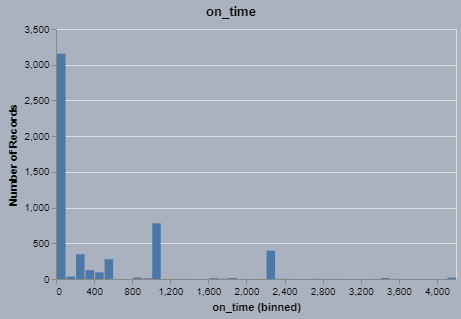

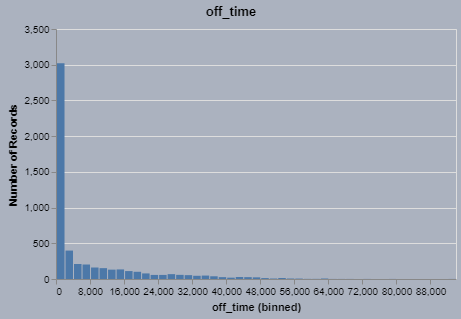

In [66]:
alt_hist(df, ['on_time','off_time'], maxbins=50)